<div style="background-color:#9696F6; color:#19180F; font-size:40px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> Table of Contents </div>
<div style="background-color:#C0C0FF; color:#19180F; font-size:20px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
1. Data Preprocessing.<br>
2. Feature Engineering.<br>
3. Exploratory Data Analysis<br>
4. Model Selection<br>
5. Hyperparameter tuning<br>
6. Feature Importances<br>
7. Model Interpretation<br>
8. Generating Submissions<br>
</div>


<div style="background-color:#C0C0FF; color:#19180F; font-size:20px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
1. Data Preprocessing </div>

In [ ]:
!pip install --upgrade pip
!pip install --upgrade setuptools
!pip install --upgrade wheel

# Add the rapidsai conda channel
!conda config --prepend channels rapidsai

# Install RAPIDS packages
!conda install -y -c rapidsai -c nvidia -c conda-forge cudf cuml


In [68]:
!pip install shap


In [70]:
#importing modules
import time
import shap
import cudf
import pandas as pd
import numpy as np
import math
import pandas as pd
import cupy as cp
import cuml
from cuml import ForestInference
from cuml.preprocessing import LabelEncoder, OneHotEncoder
from cuml.preprocessing import StandardScaler
from cuml.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
import seaborn as sns
import matplotlib.pyplot as plt
from cuml.linear_model import LogisticRegression
from cuml.svm import SVC
from cuml.neighbors import KNeighborsClassifier
from cuml.naive_bayes import MultinomialNB
from cuml.ensemble import RandomForestClassifier
from cuml.metrics import roc_auc_score
from cuml.model_selection import train_test_split
from cudf.core.column import numerical
from sklearn.model_selection import KFold
from cuml.metrics import accuracy_score


In [2]:
# Load the datasets
train_df = cudf.read_csv('/kaggle/input/home-credit-default-risk/application_train.csv')
test_df = cudf.read_csv('/kaggle/input/home-credit-default-risk/application_test.csv')
bureau_df = cudf.read_csv('/kaggle/input/home-credit-default-risk/bureau.csv')
bureau_balance_df = cudf.read_csv('/kaggle/input/home-credit-default-risk/bureau_balance.csv')
pos_cash_balance_df = cudf.read_csv('/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv')
credit_card_balance_df = cudf.read_csv('/kaggle/input/home-credit-default-risk/credit_card_balance.csv')
previous_application_df = cudf.read_csv('/kaggle/input/home-credit-default-risk/previous_application.csv')
installments_payments_df = cudf.read_csv('/kaggle/input/home-credit-default-risk/installments_payments.csv')


In [3]:
# Data cleaning
# Remove outliers
train_df = train_df[(train_df['AMT_INCOME_TOTAL'] <= 5000000) & (train_df['AMT_CREDIT'] <= 5000000)]

# Correct inconsistencies
train_df['CODE_GENDER'] = train_df['CODE_GENDER'].replace('XNA', 'F')


In [4]:
# Handle missing values
def handle_missing_values(df):
    # Fill missing numeric values with the mean
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

    # Fill missing categorical values with a placeholder value
    categorical_cols = df.select_dtypes(include=['object']).columns
    df[categorical_cols] = df[categorical_cols].fillna('Unknown')
    
    return df

In [5]:
# Handle missing values
train_df = handle_missing_values(train_df)
test_df = handle_missing_values(test_df)
bureau_df = handle_missing_values(bureau_df)
bureau_balance_df = handle_missing_values(bureau_balance_df)
pos_cash_balance_df = handle_missing_values(pos_cash_balance_df)
credit_card_balance_df = handle_missing_values(credit_card_balance_df)
previous_application_df = handle_missing_values(previous_application_df)
installments_payments_df = handle_missing_values(installments_payments_df)


In [6]:
# Print all column names of each dataframe, Mandatory to remove redundant ones
dataframes = [train_df,test_df,bureau_df,bureau_balance_df,pos_cash_balance_df,credit_card_balance_df,previous_application_df,installments_payments_df]
for dataframe in dataframes:
    for column in dataframe.columns:
        print(column)
    print("********************")

SK_ID_CURR
TARGET
NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
CNT_CHILDREN
AMT_INCOME_TOTAL
AMT_CREDIT
AMT_ANNUITY
AMT_GOODS_PRICE
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
REGION_POPULATION_RELATIVE
DAYS_BIRTH
DAYS_EMPLOYED
DAYS_REGISTRATION
DAYS_ID_PUBLISH
OWN_CAR_AGE
FLAG_MOBIL
FLAG_EMP_PHONE
FLAG_WORK_PHONE
FLAG_CONT_MOBILE
FLAG_PHONE
FLAG_EMAIL
OCCUPATION_TYPE
CNT_FAM_MEMBERS
REGION_RATING_CLIENT
REGION_RATING_CLIENT_W_CITY
WEEKDAY_APPR_PROCESS_START
HOUR_APPR_PROCESS_START
REG_REGION_NOT_LIVE_REGION
REG_REGION_NOT_WORK_REGION
LIVE_REGION_NOT_WORK_REGION
REG_CITY_NOT_LIVE_CITY
REG_CITY_NOT_WORK_CITY
LIVE_CITY_NOT_WORK_CITY
ORGANIZATION_TYPE
EXT_SOURCE_1
EXT_SOURCE_2
EXT_SOURCE_3
APARTMENTS_AVG
BASEMENTAREA_AVG
YEARS_BEGINEXPLUATATION_AVG
YEARS_BUILD_AVG
COMMONAREA_AVG
ELEVATORS_AVG
ENTRANCES_AVG
FLOORSMAX_AVG
FLOORSMIN_AVG
LANDAREA_AVG
LIVINGAPARTMENTS_AVG
LIVINGAREA_AVG
NONLIVINGAPARTMENTS_AVG
NONLIVINGAREA_AVG
APART

In [7]:
train_irrelevant_columns = [
    "SK_ID_CURR",
]

test_irrelevant_columns = [
    "SK_ID_CURR",
]

bureau_irrelevant_columns = [
    "SK_ID_CURR",
    "SK_ID_BUREAU",
]

bureau_balance_irrelevant_columns = [
    "SK_ID_BUREAU",
]

pos_cash_balance_irrelevant_columns = [
    "SK_ID_PREV",
    "SK_ID_CURR",
]

credit_card_balance_irrelevant_columns = [
    "SK_ID_PREV",
    "SK_ID_CURR",
]

previous_application_irrelevant_columns = [
    "SK_ID_PREV",
    "SK_ID_CURR",
]

installments_payments_irrelevant_columns = [
    "SK_ID_PREV",
    "SK_ID_CURR",
]


In [8]:
def clean_dataset(df, irrelevant_columns):
    # Perform data cleaning operations on the dataset
    
    # Drop irrelevant columns
    df = df.drop(irrelevant_columns, axis=1)
    
    # Perform any additional cleaning steps
    
    return df


In [9]:
# Clean and preprocess individual datasets
train_df = clean_dataset(train_df, train_irrelevant_columns)
test_df = clean_dataset(test_df, test_irrelevant_columns)
bureau_df = clean_dataset(bureau_df, bureau_irrelevant_columns)
bureau_balance_df = clean_dataset(bureau_balance_df, bureau_balance_irrelevant_columns)
pos_cash_balance_df = clean_dataset(pos_cash_balance_df, pos_cash_balance_irrelevant_columns)
credit_card_balance_df = clean_dataset(credit_card_balance_df, credit_card_balance_irrelevant_columns)
previous_application_df = clean_dataset(previous_application_df, previous_application_irrelevant_columns)
installments_payments_df = clean_dataset(installments_payments_df, installments_payments_irrelevant_columns)



<div style="background-color:#C0C0FF; color:#19180F; font-size:20px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
2. Feature Engineering </div>

In [10]:
# Add new features based on existing columns or perform transformations
train_df['CREDIT_INCOME_PERCENT'] = train_df['AMT_CREDIT'] / train_df['AMT_INCOME_TOTAL']
train_df['ANNUITY_INCOME_PERCENT'] = train_df['AMT_ANNUITY'] / train_df['AMT_INCOME_TOTAL']
train_df['CREDIT_TERM'] = train_df['AMT_ANNUITY'] / train_df['AMT_CREDIT']
train_df['DAYS_EMPLOYED_PERCENT'] = train_df['DAYS_EMPLOYED'] / train_df['DAYS_BIRTH']


In [11]:
# Add new features based on existing columns or perform transformations
test_df['CREDIT_INCOME_PERCENT'] = test_df['AMT_CREDIT'] / test_df['AMT_INCOME_TOTAL']
test_df['ANNUITY_INCOME_PERCENT'] = test_df['AMT_ANNUITY'] / test_df['AMT_INCOME_TOTAL']
test_df['CREDIT_TERM'] = test_df['AMT_ANNUITY'] / test_df['AMT_CREDIT']
test_df['DAYS_EMPLOYED_PERCENT'] = test_df['DAYS_EMPLOYED'] / test_df['DAYS_BIRTH']


<div style="background-color:#C0C0FF; color:#19180F; font-size:20px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
3. Exploratory Data Analysis </div>

In [12]:
# Calculate statistics
train_df.describe()


/opt/conda/lib/python3.10/site-packages/cudf/core/dataframe.py:4945: FutureWarning: `datetime_is_numeric` is deprecated. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/cudf/core/series.py:3133: FutureWarning: `datetime_is_numeric` is deprecated and will be removed in a future release. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  warnings.warn(


,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
count,307506.000000,307506.000000,3.075060e+05,3.075060e+05,307506.000000,3.075060e+05,307506.000000,307506.000000,307506.000000,307506.000000,...,307506.000000,307506.00000,307506.000000,307506.000000,307506.000000,307506.000000,307506.000000,307506.000000,307506.000000,307506.000000
mean,0.080727,0.417049,1.682665e+05,5.990199e+05,27107.674794,5.383902e+05,0.020868,-16037.003356,63816.132573,-4986.107930,...,0.006403,0.00700,0.034359,0.267398,0.265477,1.899977,3.957633,0.180932,0.053695,-2.920185
std,0.272416,0.722120,9.916463e+04,4.024885e+05,14490.839110,3.692761e+05,0.013831,4364.013280,141276.657448,3522.906619,...,0.077984,0.10301,0.190360,0.851930,0.738513,1.738534,2.689705,0.094571,0.022482,6.627140
min,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,-24672.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.066667,0.003333,0.018276,-47.489663
25%,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,-7480.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,2.018667,0.114786,0.036900,0.021558
50%,0.000000,0.000000,1.470735e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.500000,-4504.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,1.899977,3.265067,0.162833,0.050000,0.088645
75%,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,-2009.250000,...,0.000000,0.00000,0.000000,0.267398,0.265477,3.000000,5.159923,0.229067,0.064043,0.190999
max,1.000000,19.000000,4.500000e+06,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,0.000000,...,4.000000,9.00000,8.000000,27.000000,261.000000,25.000000,84.736842,1.875965,0.172112,0.728811


<Axes: >

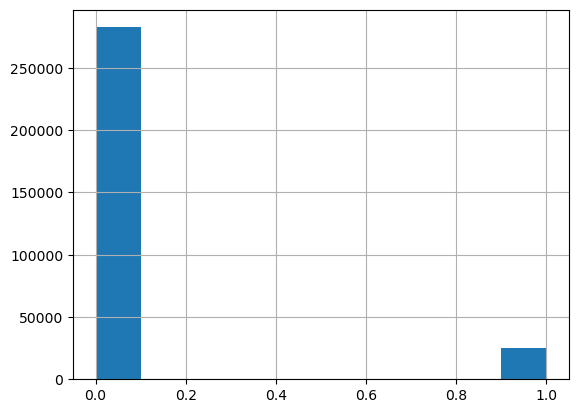

In [13]:
# Visualize distributions
train_df['TARGET'].to_pandas().hist()


In [14]:

# Identify correlations 
numeric_columns = train_df.select_dtypes(include=[cp.number]).columns
correlation_matrix = train_df[numeric_columns].corr()


/tmp/ipykernel_1258/1017057803.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  correlation_matrix_pd.loc[top_correlation_cols, top_correlation_cols],


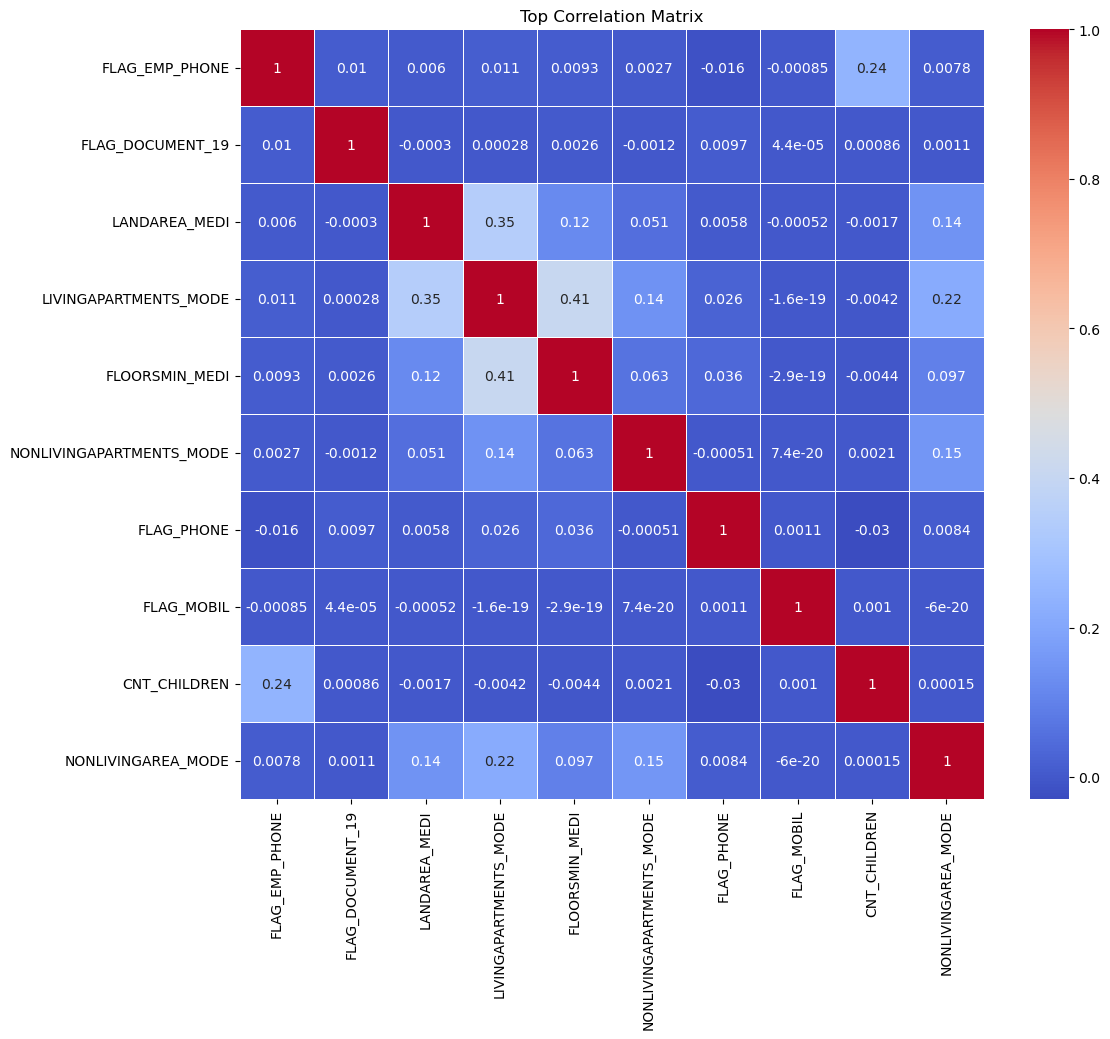

In [15]:
# Convert correlation matrix to Pandas DataFrame
correlation_matrix_pd = correlation_matrix.to_pandas()

# Set the number of top correlations to display
num_top_correlations = 10

# Get the top absolute correlations
top_correlations = correlation_matrix_pd.abs().unstack().sort_values(ascending=False)
top_correlations = top_correlations[top_correlations != 1.0]  # Exclude self-correlations
top_correlations = top_correlations[:num_top_correlations]

# Get the corresponding columns
top_correlation_cols = set()
for col1, col2 in top_correlations.index:
    top_correlation_cols.add(col1)
    top_correlation_cols.add(col2)

# Plot correlation matrix using Seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix_pd.loc[top_correlation_cols, top_correlation_cols],
    annot=True,
    cmap='coolwarm',
    linewidths=0.5
)
plt.title('Top Correlation Matrix')
plt.show()

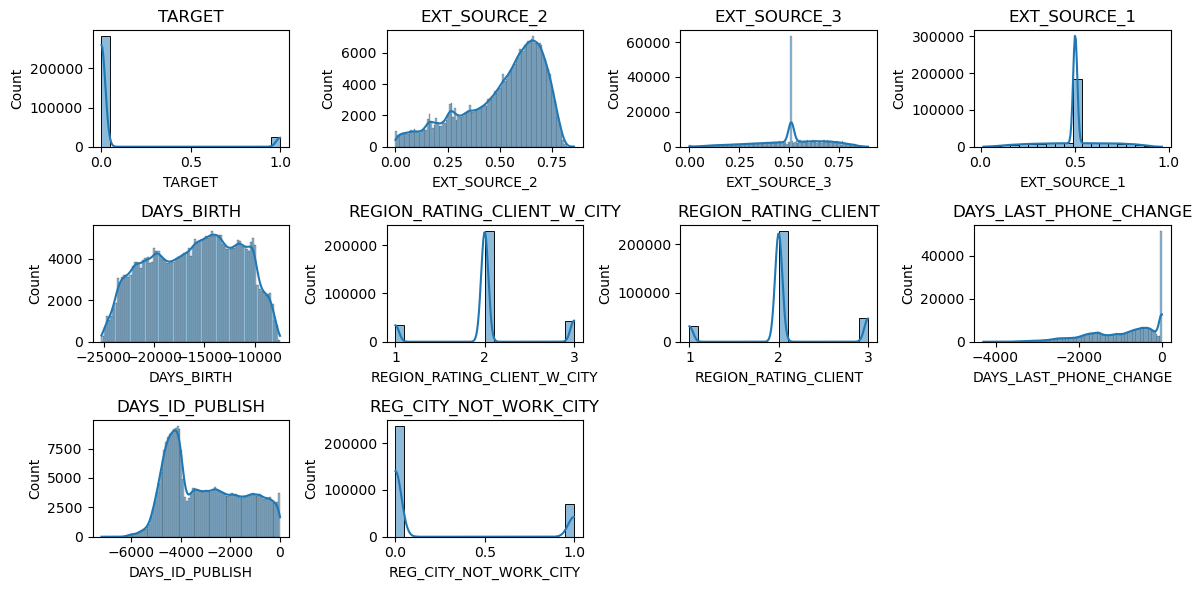

In [17]:
# Filter numeric columns (excluding object data types)
numeric_columns = train_df.select_dtypes(include=['float', 'integer']).columns

# Sort numeric features based on a specific criterion (e.g., correlation with the target variable)
numeric_features_sorted = train_df[numeric_columns].corr()['TARGET'].abs().sort_values(ascending=False)
top_numeric_features = numeric_features_sorted.index[:10]  # Select top 10 numeric features
# Convert cuDF DataFrame to pandas DataFrame
train_df_pd = train_df.to_pandas()
# Convert the StringIndex to a regular Python list
top_numeric_features = top_numeric_features.to_arrow().to_pylist()

# Calculate the number of rows and columns for subplots
num_numeric_cols = len(top_numeric_features)
num_rows = math.ceil(num_numeric_cols / 4)
num_cols = min(num_numeric_cols, 4)

# Plot distribution of top 10 numeric features
plt.figure(figsize=(12, 6))
for i, column in enumerate(top_numeric_features):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.histplot(train_df_pd[column].dropna(), kde=True)
    plt.title(column)
plt.tight_layout()
plt.show()


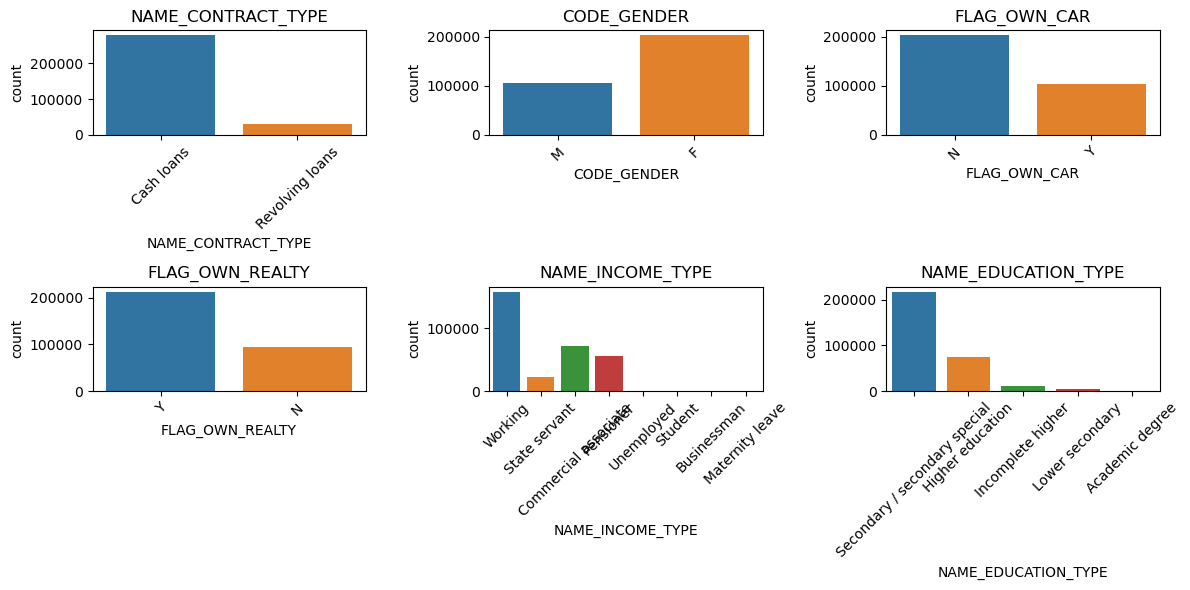

In [18]:
# Convert the categorical_columns to a regular Python list
categorical_columns = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE']

# Calculate the number of rows and columns for subplots
num_categorical_cols = len(categorical_columns)
num_rows = math.ceil(num_categorical_cols / 3)
num_cols = min(num_categorical_cols, 3)

# Plot countplot of categorical features
plt.figure(figsize=(12, 6))
for i, column in enumerate(categorical_columns):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.countplot(data=train_df_pd, x=column)
    plt.title(column)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipykernel_1258/444407909.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  numeric_features_sorted = train_df_pd.corr()['TARGET'].abs().sort_values(ascending=False)


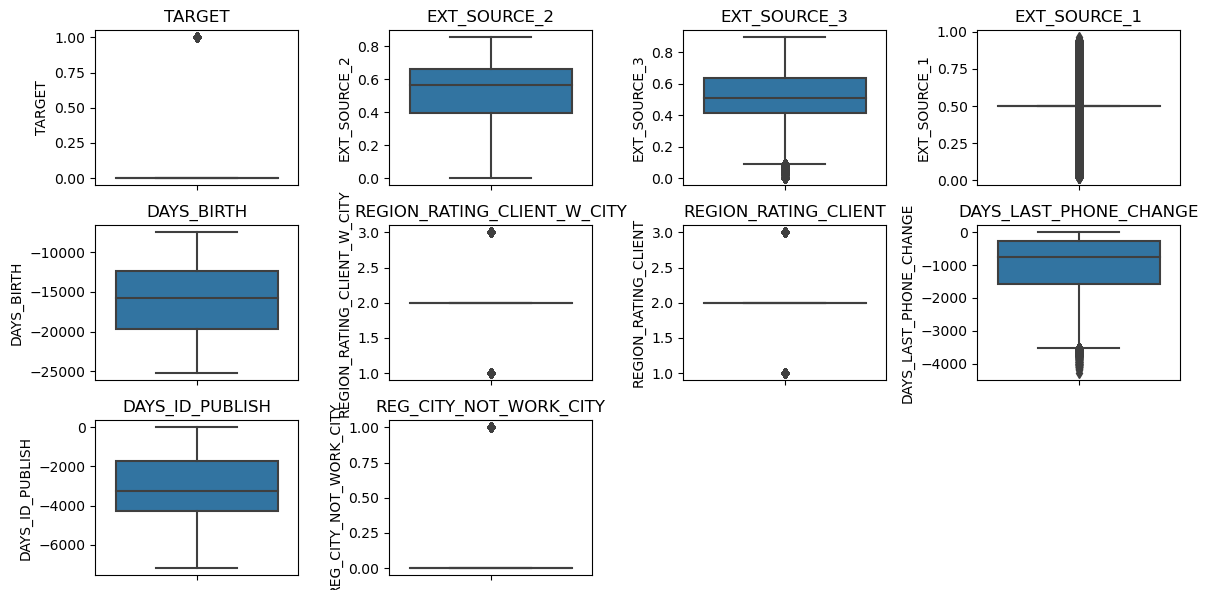

In [19]:
# Convert cuDF DataFrame to pandas DataFrame
train_df_pd = train_df.to_pandas()

# Sort numeric features based on a specific criterion (e.g., correlation with the target variable)
numeric_features_sorted = train_df_pd.corr()['TARGET'].abs().sort_values(ascending=False)
top_numeric_features = numeric_features_sorted.index[:10]  # Select top 10 numeric features

# Calculate the number of rows and columns for subplots
num_numeric_cols = len(top_numeric_features)
num_rows = math.ceil(num_numeric_cols / 4)
num_cols = min(num_numeric_cols, 4)

# Plot boxplot of top 10 numeric features
plt.figure(figsize=(12, 6))
for i, column in enumerate(top_numeric_features):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.boxplot(data=train_df_pd, y=column)
    plt.title(column)
plt.tight_layout()
plt.show()


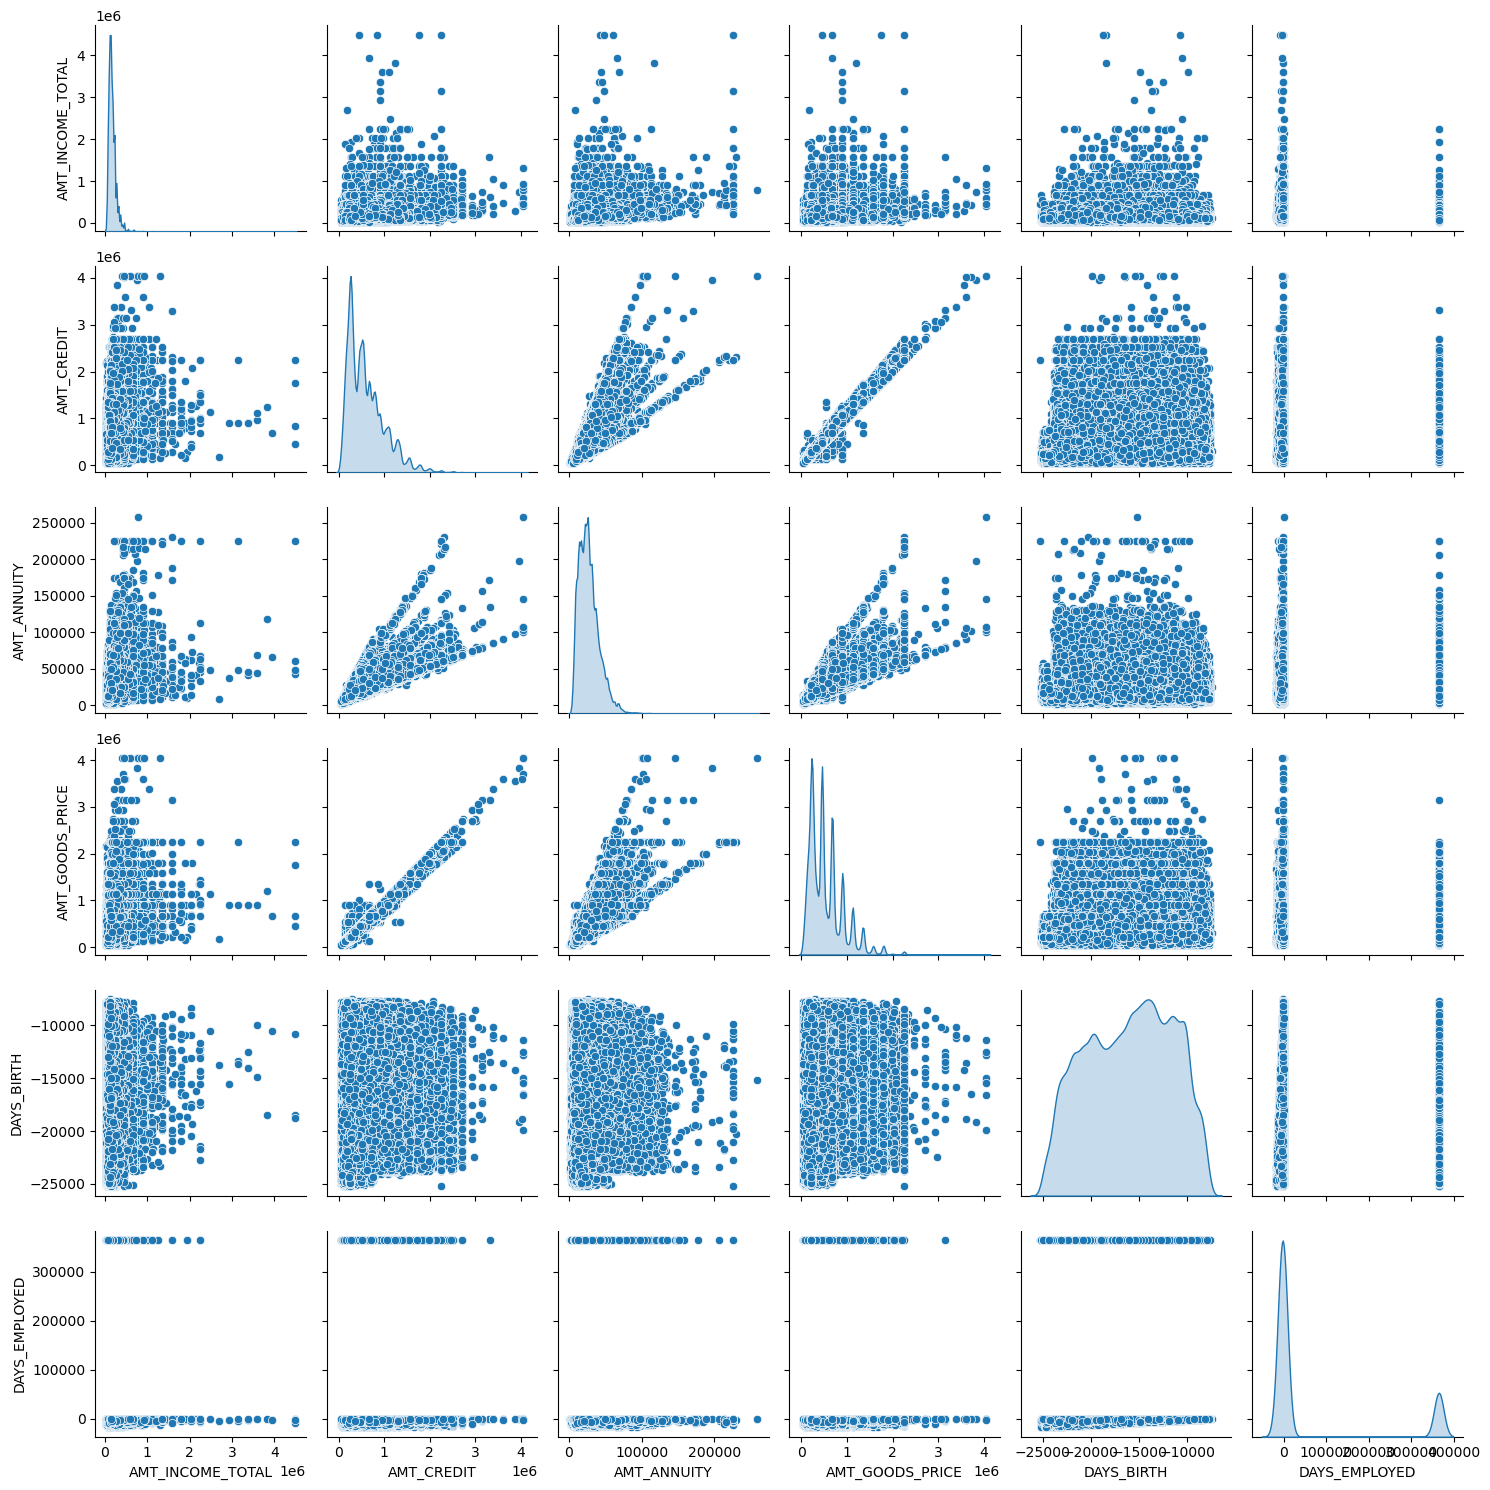

In [20]:
# Pairplot of selected numeric features
selected_numeric_columns = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_EMPLOYED']
sns.pairplot(data=train_df_pd[selected_numeric_columns].dropna(), diag_kind='kde')
plt.tight_layout()
plt.show()


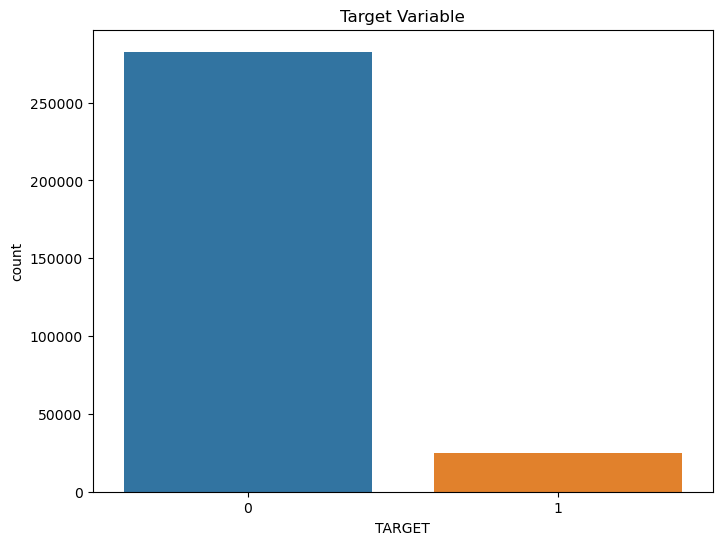

In [21]:
# Bar plot of target variable
plt.figure(figsize=(8, 6))
sns.countplot(data=train_df_pd, x='TARGET')
plt.title('Target Variable')
plt.show()

<div style="background-color:#CACAE9; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
Feel free to EDA on rest of the cleaned dataframe, too. We did for train_df only out here. Also, for sake of ensuring clear plots we used top 10 features to display in most. </div>

<div style="background-color:#C0C0FF; color:#19180F; font-size:20px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
4. Model Selection </div>

In [22]:
# Convert train_df to pandas DataFrame for compatibility with cuML
train_df_pandas = train_df.to_pandas()

# Split the data into features (X) and target variable (y)
X = train_df.drop('TARGET', axis=1)
y = train_df['TARGET']


In [23]:
# Handle non-numeric values in categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns
for column in categorical_columns:
    X[column] = X[column].fillna('').astype('str')
    label_encoder = LabelEncoder()
    X[column] = label_encoder.fit_transform(X[column])


In [24]:
# Handle missing values and scale numeric columns
numeric_columns = X.select_dtypes(include=['float32']).columns
for column in numeric_columns:
    X[column] = X[column].fillna(0)
    scaler = StandardScaler()
    X[column] = scaler.fit_transform(X[column].values.reshape(-1, 1))


In [25]:
# Convert the target variable to float32
y = y.astype('float32')


In [26]:
# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


In [48]:
# Perform K-fold cross-validation
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Define the models
models = [
    LogisticRegression(),
    RandomForestClassifier(n_estimators=100, max_depth=8),
    SVC(),
    KNeighborsClassifier(),
]

# Store accuracy for each model
model_accuracy = {}

# Train and evaluate models for each fold
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    print(f"Fold {fold + 1}:")
    for model in models:
        start_time = time.time()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        model_name = model.__class__.__name__
        if model_name not in model_accuracy:
            model_accuracy[model_name] = []
        model_accuracy[model_name].append(accuracy)
        elapsed_time = time.time() - start_time
        print(f"  Model: {model_name}, Accuracy: {accuracy}, Time taken: {elapsed_time:.2f} seconds")

[D] [11:42:30.617056] /opt/conda/conda-bld/work/python/_skbuild/linux-x86_64-3.10/cmake-build/cuml/internals/logger.cxx:3192 CY::Estimator parameters:
[D] [11:42:30.617550] /opt/conda/conda-bld/work/python/_skbuild/linux-x86_64-3.10/cmake-build/cuml/internals/logger.cxx:3192 {'C': 1.0,
 '_full_kwargs': {},
 '_input_mem_type': None,
 '_input_type': None,
 'class_weight': CumlArrayDescriptorMeta(input_type=None, values={None: None}),
 'fit_intercept': True,
 'handle': <pylibraft.common.handle.Handle object at 0x78cd62dd6790>,
 'l1_ratio': None,
 'linesearch_max_iter': 50,
 'max_iter': 1000,
 'n_features_in_': None,
 'output_mem_type': <MemoryType.device: 1>,
 'output_type': 'input',
 'penalty': 'l2',
 'solver': 'qn',
 'solver_model': QN(),
 'target_dtype': None,
 'tol': 0.0001,
 'verb_prefix': 'CY::',
 'verbose': 4}
Fold 1:
[D] [11:42:30.759630] /opt/conda/conda-bld/work/python/_skbuild/linux-x86_64-3.10/cmake-build/cuml/internals/logger.cxx:3192 CY::Setting loss to sigmoid
[D] [11:42:30

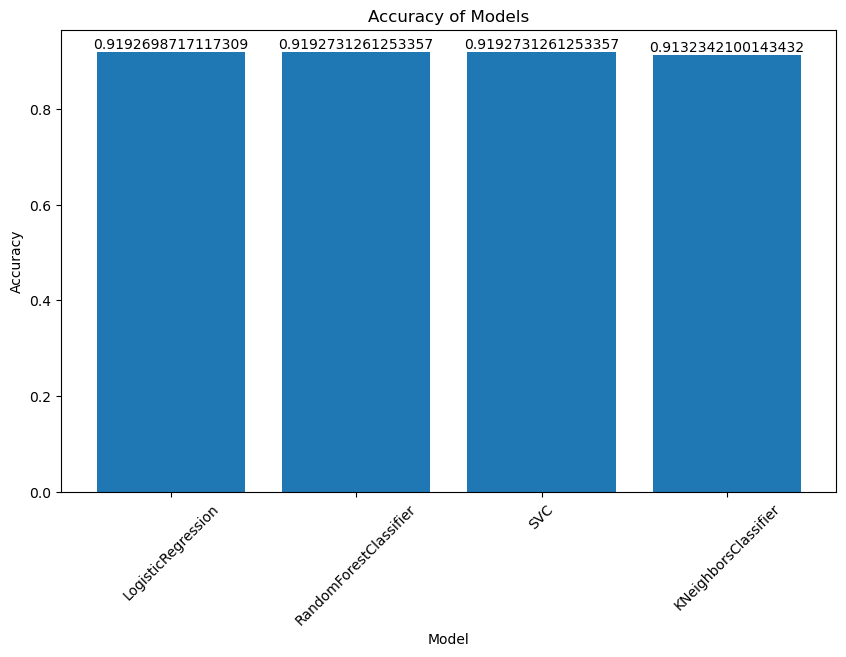

In [49]:
model_names = list(model_accuracy.keys())
accuracies = list(model_accuracy.values())

plt.figure(figsize=(10, 6))
plt.bar(model_names, np.mean(accuracies, axis=1))
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Accuracy of Models")
plt.xticks(rotation=45)

# Print accuracy over each bar
for i, acc in enumerate(np.mean(accuracies, axis=1)):
    plt.text(i, acc, f"{acc:.16f}", ha="center", va="bottom")

plt.show()


In [52]:
# Find the best model
best_model_index = np.argmax(np.mean(accuracies, axis=1))
best_model = models[best_model_index]
print(f"The best model is {best_model} with an average accuracy of {np.mean(accuracies[best_model_index])}.")

The best model is RandomForestClassifier() with an average accuracy of 0.9192731261253357.


<div style="background-color:#C0C0FF; color:#19180F; font-size:20px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
5. Hyperparameter Tuning </div>

In [54]:
from sklearn.model_selection import GridSearchCV

# Convert cuDF DataFrames to NumPy arrays
X_train_np = X_train.to_pandas().values
y_train_np = y_train.to_pandas().values

# Define the hyperparameters to tune
# Dense param grid
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [5, 10, 15],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

#sparse param grid
param_grid = {
    'n_estimators': [300],
    'max_depth': [10],
    'min_samples_split': [5],
    'min_samples_leaf': [2]
}
# Create the Random Forest Classifier model
model = RandomForestClassifier(verbose=True)

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_np, y_train_np)

# Print the best hyperparameters and the corresponding accuracy
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

/opt/conda/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/cuml/internals/

Best Hyperparameters:  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Best Accuracy:  0.9195544805999878


<div style="background-color:#CACAE9; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
There is no GridSearchCV in RapidsML, We had to perform O(n^hyperparams) instead we chose traditional method</div>
<div style="background-color:#CACAE9; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
We tune only on sparse param grid, you can tune on entire dense param grid as it will take time.</div>

In [55]:
#extracting the best_model out of it
best_model = grid_search.best_estimator_

<div style="background-color:#C0C0FF; color:#19180F; font-size:20px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
6. Feature Importances. </div>

In [65]:
from sklearn.ensemble import RandomForestClassifier

# Convert cuDF DataFrames to pandas DataFrames
X_train_pd = X_train.to_pandas()
y_train_pd = y_train.to_pandas()

# Create and train the Random Forest model using scikit-learn
model_sklearn = RandomForestClassifier(n_estimators=50, max_depth=5, min_samples_split=5, min_samples_leaf=2)
model_sklearn.fit(X_train_pd, y_train_pd)


RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=50)

<div style="background-color:#CACAE9; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
Since cuML doesn't have feature_importances like its counterpart in scikit learn so we approximate the feature importances by examining the Gini importance values of each feature via scikit learn variant</div>

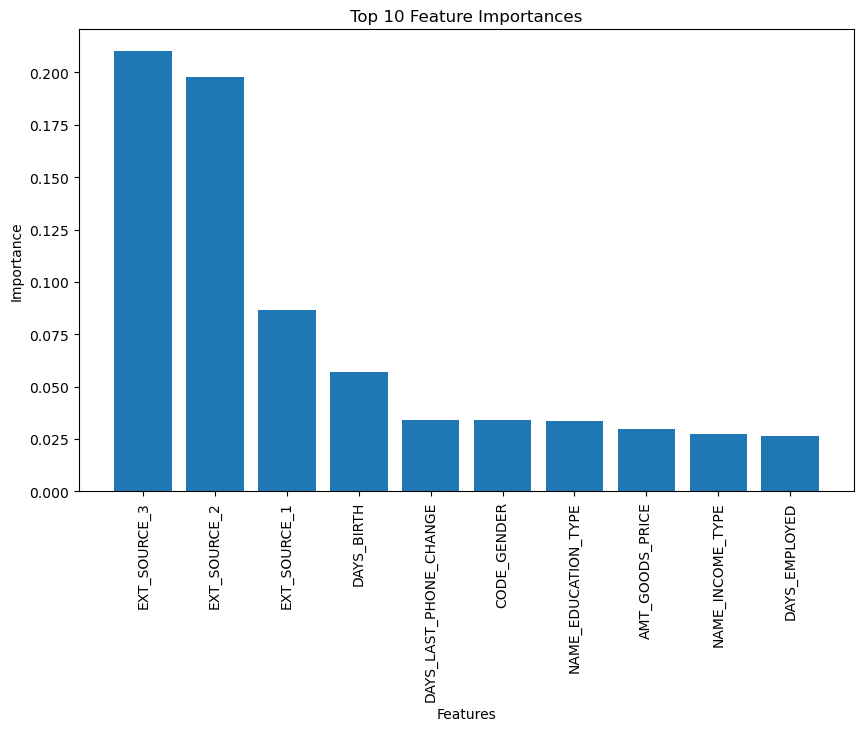

In [69]:
# Get the feature importances from scikit-learn model
importances = model_sklearn.feature_importances_

# Sort feature importances
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]
sorted_features = X_train_pd.columns[sorted_indices]

# Select top 10 features
top_features = sorted_features[:10]
top_importances = sorted_importances[:10]

# Plot feature importances for top 10 features
plt.figure(figsize=(10, 6))
plt.bar(range(len(top_features)), top_importances, tick_label=top_features)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 10 Feature Importances')
plt.show()


<div style="background-color:#C0C0FF; color:#19180F; font-size:20px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
7. Model Interpretation </div>

In [78]:
X_test_pd = X_test[:100].to_pandas()#for first 100 values


In [79]:
explainer = shap.Explainer(model_sklearn, X_test_pd)


In [80]:
shap_values = explainer.shap_values(X_test_pd)


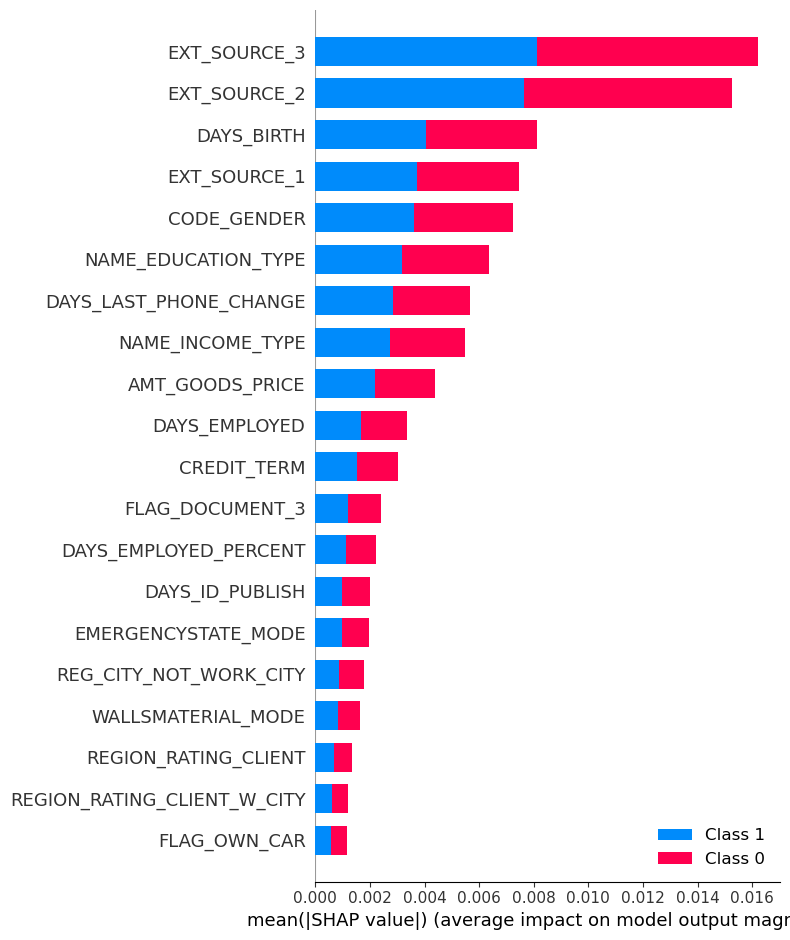

In [81]:
shap.summary_plot(shap_values, X_test_pd)


<div style="background-color:#C0C0FF; color:#19180F; font-size:20px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
8. Generating Submission </div>

In [82]:
test_df_pd = test_df.to_pandas()


In [85]:
# Handle non-numeric values in categorical columns
categorical_columns = test_df.select_dtypes(include=['object']).columns
for column in categorical_columns:
    test_df[column] = test_df[column].fillna('').astype('str')
    label_encoder = LabelEncoder()
    test_df[column] = label_encoder.fit_transform(X[column])

In [86]:
# Handle missing values and scale numeric columns
numeric_columns = test_df.select_dtypes(include=['float32']).columns
for column in numeric_columns:
    test_df[column] = test_df[column].fillna(0)
    scaler = StandardScaler()
    test_df[column] = scaler.fit_transform(test_df[column].values.reshape(-1, 1))


In [89]:
# Fill null values with column means
test_df_filled = test_df.fillna(test_df.mean().astype('uint8'))


In [96]:
# Convert the filled DataFrame to a pandas DataFrame
test_df_filled_pd = test_df_filled.to_pandas()

# Use the best_model to predict the probabilities for the TARGET variable
predictions = best_model.predict_proba(test_df_filled_pd)


In [97]:
predictions.shape

(48744, 2)

In [105]:
# Select the predicted probabilities for the positive class
predictions = predictions[1]


In [98]:
test_df.shape

(48744, 124)

In [102]:
test_df = cudf.read_csv('/kaggle/input/home-credit-default-risk/application_test.csv')
test_df_pd = test_df.to_pandas()


In [106]:
# Create a submission DataFrame with SK_ID_CURR and predicted probabilities
submission_df = pd.DataFrame({'SK_ID_CURR': test_df_pd['SK_ID_CURR'], 'TARGET': predictions})


In [107]:
# Save the submission DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

In [108]:
submission_df

,SK_ID_CURR,TARGET
0,100001,0.110301
1,100005,0.056703
2,100013,0.044340
3,100028,0.064572
4,100038,0.118002
...,...,...
48739,456221,0.042112
48740,456222,0.086754
48741,456223,0.061989
48742,456224,0.064530
